In [76]:
import json
from PIL import Image
from PIL import ImageDraw
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import numpy as np
import copy

In [ ]:
# Going to use TrashCAN 1.0 Dataset (https://conservancy.umn.edu/handle/11299/214865)
# Specifically, use TrashCAN-Material sub-dataset with the following classes:

'''
            'rov':                  1,
            'plant':                2,
            'animal_fish':          3,
            'animal_starfish':      4,
            'animal_shells':        5,
            'animal_crab':          6,
            'animal_eel':           7,
            'animal_etc':           8,
            'trash_etc':            9,
            'trash_fabric':         10,
            'trash_fishing_gear':   11,
            'trash_metal':          12,
            'trash_paper':          13,
            'trash_plastic':        14,
            'trash_rubber':         15,
            'trash_wood':           16
'''

# Reference paper: https://arxiv.org/pdf/2007.08097.pdf

# This dataset includes both detection and segmentation labels (going to just focus on detection)


### First prepare the training dataset

In [402]:
# parse provided json file which contains annotations for each image

ann_dict = {}

with open('trash_CAN20/material_version/instances_train_trashcan.json') as ann:
    ann_dict = json.load(ann)

In [273]:
ann_dict.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [274]:
len(ann_dict['images'])

6008

In [275]:
# need to extract bounding boxes for each image (remove segmentation related stuff) 

ann_dict['annotations']

[{'segmentation': [[240.0,
    343.99468085106383,
    250.0,
    339.98,
    255.99717514124293,
    330.0,
    255.99603174603175,
    319.0,
    252.998031496063,
    313.0,
    254.9972972972973,
    295.0,
    270.0,
    287.92857142857144,
    275.96153846153845,
    280.0,
    274.995867768595,
    268.0,
    271.98,
    259.0,
    264.9980392156863,
    252.0,
    268.9931506849315,
    248.0,
    273.975,
    239.0,
    274.9980392156863,
    222.0,
    285.995,
    210.0,
    290.98214285714283,
    197.0,
    290.9375,
    181.0,
    287.99768518518516,
    172.0,
    278.0,
    161.01666666666668,
    271.0,
    157.00387596899225,
    260.0,
    157.00877192982455,
    250.0,
    159.08333333333334,
    232.0,
    168.00320512820514,
    222.0042735042735,
    180.0,
    214.00200803212851,
    199.0,
    210.0,
    203.00196078431372,
    193.0,
    207.00196078431372,
    179.0,
    208.00396825396825,
    166.0,
    214.0079365079365,
    157.01388888888889,
    224.0,


In [276]:
ann_dict['images']

[{'id': 1,
  'file_name': 'vid_000421_frame0000005.jpg',
  'width': 480,
  'height': 360},
 {'id': 2,
  'file_name': 'vid_000106_frame0000015.jpg',
  'width': 480,
  'height': 360},
 {'id': 3,
  'file_name': 'vid_000158_frame0000044.jpg',
  'width': 480,
  'height': 270},
 {'id': 4,
  'file_name': 'vid_000044_frame0000021.jpg',
  'width': 480,
  'height': 270},
 {'id': 5,
  'file_name': 'vid_000437_frame0000015.jpg',
  'width': 480,
  'height': 360},
 {'id': 6,
  'file_name': 'vid_000132_frame0000098.jpg',
  'width': 480,
  'height': 270},
 {'id': 7,
  'file_name': 'vid_000109_frame0000036.jpg',
  'width': 480,
  'height': 360},
 {'id': 8,
  'file_name': 'vid_000285_frame0000022.jpg',
  'width': 480,
  'height': 360},
 {'id': 9,
  'file_name': 'vid_000539_frame0000057.jpg',
  'width': 480,
  'height': 270},
 {'id': 10,
  'file_name': 'vid_000346_frame0000020.jpg',
  'width': 480,
  'height': 270},
 {'id': 11,
  'file_name': 'vid_000331_frame0000158.jpg',
  'width': 480,
  'height': 270

In [403]:
# compile the relevant data into a pickle file 
# (from this point on, just load in pickle file and folder with image files to work with data)

# do images first so can just do a join later:
images = pd.DataFrame(ann_dict['images'])
images = images.rename(columns={'id': 'image_id'})

# now do annotations
data = pd.DataFrame(ann_dict['annotations'])
data = data.drop(['segmentation', 'iscrowd', 'area'], axis=1)

# merge the two dataframes to give final pickle file
# note, have to use pickle file because bbox contains lists which get read in as strings from csv
data = data.merge(images, on='image_id')
data = data[['image_id', 'id', 'file_name', 'category_id', 'bbox', 'width', 'height']]
data.image_id -= 1
data.to_pickle('UTD_train.pkl', protocol=4)
data

image_id    id                    file_name  category_id  \
0            0     1  vid_000421_frame0000005.jpg            8   
1            1     2  vid_000106_frame0000015.jpg            2   
2            1     3  vid_000106_frame0000015.jpg            4   
3            1     4  vid_000106_frame0000015.jpg            4   
4            1     5  vid_000106_frame0000015.jpg            4   
...        ...   ...                          ...          ...   
9736      6005  9737  vid_000131_frame0000018.jpg            1   
9737      6005  9738  vid_000131_frame0000018.jpg            9   
9738      6006  9739  vid_000551_frame0000067.jpg            8   
9739      6006  9740  vid_000551_frame0000067.jpg            4   
9740      6007  9741  vid_000350_frame0000213.jpg           12   

                                                   bbox  width  height  
0     [135.00375939849624, 157.00387596899225, 155.9...    480     360  
1     [1.0019607843137255, 171.00196078431372, 476.9...    480     360  
2     [233.00833333333333, 252.0040322580645, 38.986...    480     360  
3     [270.03125, 246.00342465753425, 39.96199324324...    480     360  
4     [5.004464285714286, 238.00409836065575, 34.979...    480     360  
...                                                 ...    ...     ...  
9736  [0.001968503937007874, 256.00409836065575, 59....    480     270  
9737  [167.00434782608696, 207.0108695652174, 70.991...    480     270  
9738  [151.00255102040816, 144.00213675213675, 76.99...    480     270  
9739  [0.00196078431372549, 28.05, 123.9980392156862...    480     270  
9740  [356.0019607843137, 134.00196078431372, 64.996...    480     270  

[9741 rows x 7 columns]

In [416]:
for box in list(data.bbox.values):
    max_ = max(box)
    idx = box.index(max_)
    if (idx == 2) or (idx == 3):
        print(max_, idx)
        
# xmin, ymin, width, height

186.9908048820716 3
476.99607843137255 2
478.9906168710516 2
256.99607843137255 3
360.99607843137255 3
217.99607843137255 2
221.99607843137255 2
268.97653194263364 2
100.9799339598679 2
479.997619047619 2
475.99607843137255 2
316.993964509251 2
365.99607843137255 2
190.99607843137255 2
423.9794546850998 2
264.99607843137255 2
103.98598191214471 2
440.9937657114128 2
395.9852917665867 2
359.9813725490196 3
451.99428424926106 2
330.99374805840324 2
175.99803921568628 2
256.99607843137255 3
480.99607843137255 2
194.99602308665402 2
225.97866263440864 2
477.99607843137255 2
479.99607843137255 2
256.99607843137255 3
204.974375 2
313.98710317460313 2
223.99607843137255 2
273.99607843137255 2
344.99607843137255 3
194.99603921568627 3
454.99337037037037 2
366.9944888565891 2
334.99607843137255 2
300.99607843137255 2
361.871875 2
480.9932909869954 2
195.9958632478632 3
338.99607843137255 3
223.99607843137255 2
217.9936144369252 2
282.9782021604938 2
268.96824596774195 2
271.7480392156863 2
424.

47.96625 3
473.99323844994234 2
313.9950452037102 2
243.96356107660455 2
218.99803921568628 2
202.99607843137255 2
478.99607843137255 2
170.99128245892953 2
359.99607843137255 3
265.99607843137255 3
255.99607843137255 3
230.9908963585434 2
400.99607843137255 2
321.99607843137255 2
424.99607843137255 2
374.9909818916384 2
290.99607843137255 2
331.99607843137255 2
479.9900545741778 2
208.99422799422797 3
347.99607843137255 2
388.99607843137255 2
287.9795206971678 2
218.99607843137255 2
273.9594892812106 3
448.9812056737589 2
132.99513223894206 3
293.9923076923077 2
446.9667892156863 2
480.99347936646325 2
248.99607843137255 3
424.9980392156863 2
255.99607843137255 3
274.99607843137255 2
131.98927847000868 2
480.9930392156863 2
417.9912824589295 2
128.9829365079365 2
117.99607843137255 2
202.9348821989529 2
146.99607843137255 3
265.99607843137255 3
242.99112363508277 2
478.99607843137255 2
445.9818548387097 2
480.98295759527645 2
216.99607843137255 2
161.99110986860495 3
372.9960784313725

479.99487465872426 2
203.9923188405797 3
141.99607843137255 2
211.99607843137255 2
234.99607843137255 2
426.92622401073106 2
338.9938524590164 2
480.9956807251202 2
220.99607843137255 2
281.9943078724027 3
219.99607843137255 2
255.99607843137255 3
157.99607843137255 3
306.99607843137255 2
190.99607843137255 3
302.9829954954955 2
166.99508553509162 3
159.9661321989529 2
480.99603958843085 2
297.99607843137255 2
252.99607843137255 3
144.99607843137255 2
475.9949904351985 2
386.9980392156863 2
427.99283088235296 2
480.99607843137255 2
175.99607843137255 2
480.99607843137255 2
287.99607843137255 3
371.9866567460317 2
303.9980392156863 2
338.99607843137255 2
309.9346428571429 2
305.99607843137255 2
480.9938253012048 2
238.99607843137255 2
345.99607843137255 3
371.9886546184739 2
368.9940562673359 2
318.98844537815125 2
187.96140350877195 2
208.99607843137255 2
219.9912452775356 2
358.99607843137255 3
327.99607843137255 2
454.9980392156863 2
479.99607843137255 2
306.99607843137255 3
426.9960

235.98241421568628 2
346.99607843137255 2
217.99607843137255 2
480.99607843137255 2
304.99607843137255 2
195.99607843137255 2
353.99607843137255 3
454.99607843137255 2
154.99607843137255 3
254.99607843137255 3
208.99607843137255 2
480.99607843137255 2
203.99607843137255 2
480.99595081967215 2
465.9908656962696 2
278.99607843137255 2
255.9853381849315 2
293.99719101123594 2
245.99122536945816 2
456.99607843137255 2
79.99607843137255 2
270.99607843137255 3
143.99607843137255 3
223.99607843137255 2
480.9913449163449 2
193.99607843137255 2
479.9980392156863 2
480.99607843137255 2
175.99607843137255 2
241.99607843137255 2
480.99607843137255 2
240.99607843137255 2
479.99607843137255 2
177.99607843137255 2
460.99607843137255 2
339.99607843137255 3
314.99607843137255 2
216.99607843137255 2
208.98692810457516 2
193.9845029239766 2
225.9906962785114 2
397.9949527959332 2
219.99607843137255 2
335.99607843137255 2
423.99607843137255 2
210.93475274725273 2
244.99607843137255 2
396.99607843137255 2


479.9980392156863 2
245.99607843137255 2
168.99607843137255 3
264.99607843137255 2
479.99607843137255 2
423.99607843137255 2
383.99607843137255 2
365.9924107142857 2
121.99520524708811 3
266.99607843137255 2
261.99607843137255 2
332.99607843137255 2
220.99607843137255 2
370.9980392156863 2
477.99607843137255 2
370.99607843137255 2
276.99462101984307 2
249.99607843137255 3
108.99362509992007 2
127.98116826503924 3
326.9878632478633 2
266.99607843137255 3
208.99607843137255 2
480.995152792413 2
148.9939393939394 3
170.97326388888888 3
229.99607843137255 2
254.99353335743263 3
479.9940476190476 2
450.9904276087915 2
264.99607843137255 2
357.99607843137255 3
178.99265901482545 3
129.99607843137255 2
172.99430778934092 2
230.99607843137255 3
242.96546052631578 2
479.99795918367346 2
230.99607843137255 3
416.99607843137255 2
462.9945427121898 2
290.99607843137255 2
249.99607843137255 2
416.99569651649205 2
181.98795712484238 2
309.99607843137255 2
148.99607843137255 3
340.99607843137255 2
25

363.9948513160538 2
305.99607843137255 2
474.99607843137255 2
261.9980392156863 2
205.9943431996086 3
230.99288457651102 2
413.99607843137255 2
297.99607843137255 2
360.8962686567164 2
142.9885635289682 3
270.99607843137255 3
191.99607843137255 3
478.91470588235296 2
415.99607843137255 2
347.99607843137255 2
453.99607843137255 2
106.99563356164384 2
205.99607843137255 3
480.9901689708141 2
373.99607843137255 2
119.99607843137255 2
246.99607843137255 2
183.99607843137255 3
213.99607843137255 2
480.99607843137255 2
480.9903100775194 2
480.9960149241883 2
329.99607843137255 2
194.4875 2
199.99607843137255 2
479.9980392156863 2
354.9355392156863 3
163.49803921568628 3
216.99607843137255 2
469.9734848484849 2
214.9831349206349 2
209.99497537935883 2
259.7480392156863 3
270.99607843137255 3
152.99607843137255 3
262.99607843137255 3
477.99414500593747 2
270.99607843137255 3
294.4969512195122 2
324.98906449553 2
479.97511574074076 2
222.99607843137255 2
254.99607843137255 3
199.99607843137255 

In [401]:
data.height.unique()

array([360, 270])

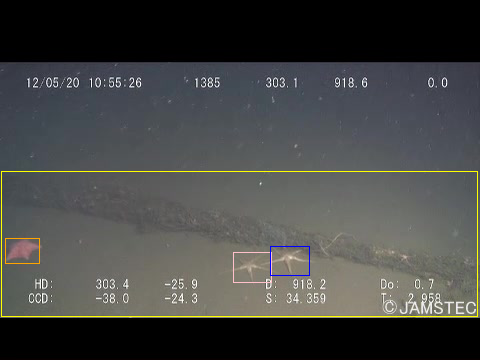

In [281]:
# test out ground truth bounding boxes

# bbox = (xmin, ymin, width, height) !!!

xmin, ymin, width, height = data.iloc[1].bbox
xmax = xmin + width
ymax = ymin + height

xmin2, ymin2, width2, height2 = data.iloc[2].bbox
xmax2 = xmin2 + width2
ymax2 = ymin2 + height2

xmin3, ymin3, width3, height3 = data.iloc[3].bbox
xmax3 = xmin3 + width3
ymax3 = ymin3 + height3

xmin4, ymin4, width4, height4 = data.iloc[4].bbox
xmax4 = xmin4 + width4
ymax4 = ymin4 + height4


test_image = Image.open("trash_CAN20/material_version/train/vid_000106_frame0000015.jpg")

draw = ImageDraw.Draw(test_image)
draw.rectangle([(xmin, ymin), (xmax, ymax)], outline="yellow") # label is plant
draw.rectangle([(xmin2, ymin2), (xmax2, ymax2)], outline="pink") # label is starfish
draw.rectangle([(xmin3, ymin3), (xmax3, ymax3)], outline="blue") # label is starfish
draw.rectangle([(xmin4, ymin4), (xmax4, ymax4)], outline="orange") # label is starfish

test_image

In [431]:
# function to show the ground truth bounding boxes and labels for any image in dataset

def display_groundtruth(filename, data): # data is the dataframe above
    temp = data[data.file_name == filename]
    category_ids = temp.category_id
    box_list = temp.bbox.values

    image = Image.open('trash_CAN20/material_version/val/' + filename)
    draw = ImageDraw.Draw(image)
    
    for (xmin, ymin, width, height), label in zip(box_list, category_ids):
        xmax = xmin + width
        ymax = ymin + height
        
        draw.rectangle([(xmin, ymin), (xmax, ymax)], outline='yellow')
        draw.text((xmin, ymin), text=str(label))
        
        print(xmin, ymin, width, height, xmax, ymax)
    
    return image

# test_list = ['vid_000434_frame0000017.jpg', 'vid_000443_frame0000089.jpg', 'vid_000501_frame0000001.jpg',
#             'vid_000553_frame0000013.jpg', 'vid_000555_frame0000038.jpg']

# for i,im in enumerate(test_list):
#     plt.figure(i)
#     plt.imshow(display_groundtruth(im, data))

0.00196078431372549 0.00196078431372549 146.99607843137255 360.99607843137255 146.99803921568628 360.9980392156863
390.0040650406504 100.00297619047619 47.99318770660233 24.994572829131656 437.99725274725273 124.99754901960785


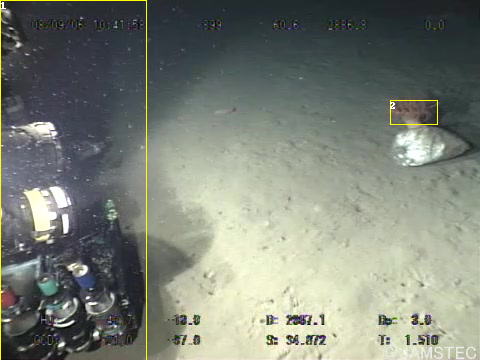

In [408]:
display_groundtruth('vid_000285_frame0000022.jpg', data)

# example of data point where bounding box is greater than image (affecting standardization step later) 

22.002450980392158 158.00236966824644 23.991596638655462 26.991677950801176 45.99404761904762 184.99404761904762
21.002463054187192 156.01 23.994629969068622 27.987487437185933 44.997093023255815 183.99748743718592
32.00526315789474 140.015625 39.991974411166034 17.982265295358644 71.99723756906077 157.99789029535864
32.00526315789474 140.015625 39.991974411166034 17.982265295358644 71.99723756906077 157.99789029535864
31.011363636363637 140.001968503937 40.986570247933884 17.992007399677448 71.99793388429752 157.99397590361446


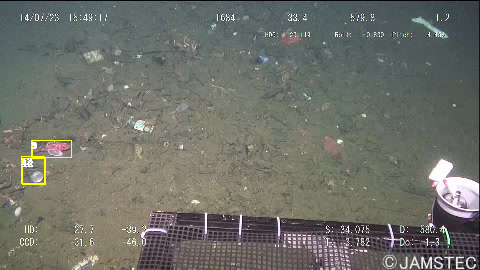

In [425]:
display_groundtruth('vid_000532_frame0000001.jpg', data)

In [419]:
data[data.file_name == 'vid_000532_frame0000001.jpg']

image_id   id                    file_name  category_id  \
959       597  960  vid_000532_frame0000001.jpg           12   
960       597  961  vid_000532_frame0000001.jpg           12   
961       597  962  vid_000532_frame0000001.jpg            9   
962       597  963  vid_000532_frame0000001.jpg            9   
963       597  964  vid_000532_frame0000001.jpg            3   

                                                  bbox  width  height  
959  [22.002450980392158, 158.00236966824644, 23.99...    480     270  
960  [21.002463054187192, 156.01, 23.99462996906862...    480     270  
961  [32.00526315789474, 140.015625, 39.99197441116...    480     270  
962  [32.00526315789474, 140.015625, 39.99197441116...    480     270  
963  [31.011363636363637, 140.001968503937, 40.9865...    480     270

In [49]:
# construct Dataset class for pytorch

class UnderwaterTrashDataset(torch.utils.data.Dataset):
    '''
    Pytorch Dataset class for Underwater Trash Dataset (Trash_CAN 1.0)
    
    data_file_path := path to pickle file containing dataset (annotations and filenames to images)
    images_path := path to folder containing actual image files
    transforms := from references/detection/transforms.py (pytorch), helps with data transformation and augmentation
    '''
    
    def __init__(self, data_file_path, images_path, transforms=None):
        if data_file_path:
            self.data = pd.read_pickle(data_file_path)
        self.images_path = images_path
        self.transforms = transforms
    
    
    def __getitem__(self, idx):
        temp = data[data.image_id == idx+1]
        
        image = Image.open(os.path.join(self.images_path, temp.file_name.iloc[0])).convert("RGB")
        
        box_list = copy.deepcopy(list(temp.bbox))

        for box in box_list: # xmax = xmin + width, ymax = ymin + height
            box[2] = box[2] + box[0]
            box[3] = box[3] + box[1]
        
        box_list = torch.as_tensor(box_list, dtype=torch.float32)
        
        labels = torch.as_tensor(temp.category_id.values, dtype=torch.int64)
        
        image_id = torch.tensor([idx])
        
        area = (box_list[:, 3] - box_list[:, 1]) * (box_list[:, 2] - box_list[:,0])
        
        iscrowd = torch.zeros((len(box_list),), dtype=torch.int64)
        
        target = {}
        target["boxes"] = box_list
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        if self.transforms:
            image, target = self.transforms(image, target)
            
        return image, target

    
    def __len__(self):
        return self.data.image_id.nunique()
    
    
 

In [50]:
trial = UnderwaterTrashDataset('UTD_dataset.pkl', 'trash_CAN20/material_version/train/')

In [51]:
trial[1] # get item works!

(<PIL.Image.Image image mode=RGB size=480x360 at 0x7FDE9203E910>,
 {'boxes': tensor([[  1.0020, 171.0020, 477.9980, 316.9980],
          [233.0083, 252.0040, 271.9950, 282.9960],
          [270.0312, 246.0034, 309.9933, 275.9933],
          [  5.0045, 238.0041,  39.9839, 263.9688]]),
  'labels': tensor([2, 4, 4, 4]),
  'image_id': tensor([1]),
  'area': tensor([69639.5625,  1208.2725,  1198.4541,   908.2279]),
  'iscrowd': tensor([0, 0, 0, 0])})

In [52]:
len(trial) # len works!

6008

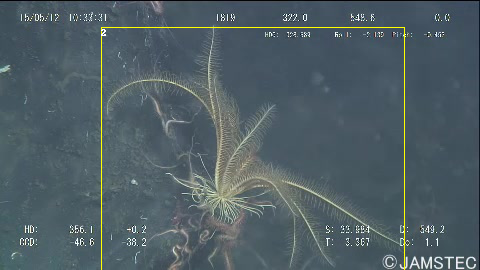

In [63]:
idx = 5555

image = trial[idx][0]
target = trial[idx][1]

draw = ImageDraw.Draw(image)

for (xmin, ymin, xmax, ymax), label in zip(target['boxes'], target['labels']):
    draw.rectangle([(xmin, ymin), (xmax, ymax)], outline='yellow')
    draw.text((xmin, ymin), text=str(label.item()))
    
image

### Also prepare the val and test datasets

In [316]:
# parse provided json file which contains annotations for each image

val_dict = {}

with open('trash_CAN20/material_version/instances_val_trashcan.json') as val:
    val_dict = json.load(val)

In [317]:
val_dict.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [318]:
len(val_dict['images'])

1204

In [178]:
val_dict['annotations']

[{'segmentation': [[179.0,
    226.99803921568628,
    180.99707602339183,
    224.0,
    180.0,
    223.00292397660817,
    164.0,
    221.00196078431372,
    162.0,
    216.00219298245614,
    154.0,
    218.00196078431372,
    152.00196078431372,
    221.0,
    152.00196078431372,
    223.0,
    157.0,
    226.99576271186442,
    179.0,
    226.99803921568628]],
  'area': 182.33937845562576,
  'iscrowd': 0,
  'image_id': 6009,
  'bbox': [152.00196078431372,
   216.00219298245614,
   28.995115239078103,
   10.99584623323014],
  'category_id': 3,
  'id': 9742},
 {'segmentation': [[128.0,
    134.984375,
    130.99375,
    132.0,
    130.9915254237288,
    129.0,
    122.0,
    117.03125,
    125.0,
    108.99802371541502,
    132.9891304347826,
    105.0,
    163.0,
    98.9957627118644,
    166.98958333333334,
    97.0,
    181.0,
    96.9957627118644,
    183.99576271186442,
    94.0,
    182.98888888888888,
    90.0,
    166.0,
    89.01612903225806,
    162.015625,
    91.0,
    1

In [319]:
# compile the relevant data into a pickle file 
# (from this point on, just load in pickle file and folder with image files to work with data)

# do images first so can just do a join later:
images = pd.DataFrame(val_dict['images'])
images = images.rename(columns={'id': 'image_id'})

# now do annotations
data = pd.DataFrame(val_dict['annotations'])
data = data.drop(['segmentation', 'iscrowd', 'area'], axis=1)

# merge the two dataframes to give final pickle file
# note, have to use pickle file because bbox contains lists which get read in as strings from csv
data = data.merge(images, on='image_id')
data = data[['image_id', 'id', 'file_name', 'category_id', 'bbox', 'width', 'height']]
# data.to_pickle('UTD_val.pkl', protocol=4)
data.image_id = data.image_id - data.image_id[0]
data

image_id     id                    file_name  category_id  \
0            0   9742  vid_000342_frame0000228.jpg            3   
1            1   9743  vid_000142_frame0000034.jpg           14   
2            1   9744  vid_000142_frame0000034.jpg           14   
3            2   9745  vid_000039_frame0000001.jpg            1   
4            3   9746  vid_000234_frame0000001.jpg           16   
...        ...    ...                          ...          ...   
2590      1202  12332  vid_000102_frame0000006.jpg            5   
2591      1202  12333  vid_000102_frame0000006.jpg            6   
2592      1202  12334  vid_000102_frame0000006.jpg           12   
2593      1203  12335  vid_000146_frame0000016.jpg           12   
2594      1203  12336  vid_000146_frame0000016.jpg            1   

                                                   bbox  width  height  
0     [152.00196078431372, 216.00219298245614, 28.99...    480     270  
1     [115.0047619047619, 89.01612903225806, 365.993...    480     270  
2     [71.00196078431372, 70.00196078431372, 276.996...    480     270  
3     [0.00196078431372549, 96.00242718446601, 131.9...    480     270  
4     [160.00196078431372, 101.00196078431372, 145.9...    480     360  
...                                                 ...    ...     ...  
2590  [329.0111111111111, 182.0084745762712, 102.985...    480     270  
2591  [377.0059523809524, 68.0111111111111, 32.99112...    480     270  
2592  [208.01612903225808, 112.0020325203252, 62.975...    480     270  
2593  [184.00196078431372, 187.00196078431372, 32.99...    480     270  
2594  [0.00196078431372549, 190.00196078431372, 208....    480     270  

[2595 rows x 7 columns]

In [320]:
data.category_id.nunique()

16

In [321]:
data.category_id.value_counts()

1     664
9     409
14    374
12    225
3     153
4     124
2     102
5      78
7      76
16     69
11     69
10     67
6      62
8      55
13     39
15     29
Name: category_id, dtype: int64

(array([851., 287.,  39.,  10.,   5.,   5.,   4.,   2.,   0.,   1.]),
 array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. , 11.8, 13.6, 15.4, 17.2, 19. ]),
 <BarContainer object of 10 artists>)

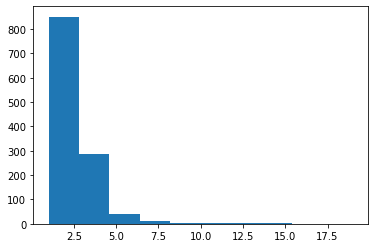

In [188]:
plt.hist(data.image_id.value_counts())

# most of the val dataset has 2 bounding boxes

In [310]:
len(data.image_id.value_counts())

1204

In [311]:
t = data.image_id.value_counts()
t[t == 2] 

1011    2
1163    2
1191    2
1118    2
1122    2
       ..
976     2
978     2
18      2
14      2
38      2
Name: image_id, Length: 343, dtype: int64

In [313]:
343/1204

0.28488372093023256

In [314]:
data[data['image_id'].map(data['image_id'].value_counts()) == 2].category_id.unique()

# we can take this ~30% of the val dataset and use it as test data (held out)
# all the images in this set have 2 bounding boxes (given)
# here we can verify that all the 16 categories are represented in this set

array([14,  1, 12,  3, 11,  4,  7,  9, 15, 16, 10,  2, 13,  6,  8,  5])

In [322]:
test = data[data['image_id'].map(data['image_id'].value_counts()) == 2]
test

image_id     id                    file_name  category_id  \
1            1   9743  vid_000142_frame0000034.jpg           14   
2            1   9744  vid_000142_frame0000034.jpg           14   
5            4   9747  vid_000074_frame0000052.jpg            1   
6            4   9748  vid_000074_frame0000052.jpg           12   
7            5   9749  vid_000153_frame0000013.jpg            3   
...        ...    ...                          ...          ...   
2584      1198  12326  vid_000119_frame0000017.jpg            8   
2587      1201  12329  vid_000036_frame0000006.jpg            1   
2588      1201  12330  vid_000036_frame0000006.jpg           14   
2593      1203  12335  vid_000146_frame0000016.jpg           12   
2594      1203  12336  vid_000146_frame0000016.jpg            1   

                                                   bbox  width  height  
1     [115.0047619047619, 89.01612903225806, 365.993...    480     270  
2     [71.00196078431372, 70.00196078431372, 276.996...    480     270  
5     [100.05, 0.00196078431372549, 379.95, 270.9960...    480     270  
6     [163.00595238095238, 54.001960784313724, 24.99...    480     270  
7     [312.0030487804878, 235.0026455026455, 13.9932...    480     360  
...                                                 ...    ...     ...  
2584  [235.00196078431372, 160.00196078431372, 21.99...    480     270  
2587  [0.001968503937007874, 88.00196078431372, 215....    480     270  
2588  [148.00531914893617, 154.01162790697674, 55.97...    480     270  
2593  [184.00196078431372, 187.00196078431372, 32.99...    480     270  
2594  [0.00196078431372549, 190.00196078431372, 208....    480     270  

[686 rows x 7 columns]

In [323]:
data = data[~data.index.isin(test.index)]

In [324]:
data.category_id.nunique()

16

In [325]:
test.category_id.nunique()

16

In [326]:
len(data)

1909

In [327]:
len(test)

686

In [299]:
data.image_id.nunique()

861

In [300]:
test.image_id.nunique()

343

In [236]:
861/6008

0.14330892143808255

In [259]:
(data.category_id - 1).unique()

array([ 2,  0, 15,  8, 11, 13,  6,  4,  7, 10,  9,  1, 14,  3, 12,  5])

In [331]:
# data = data.reset_index(drop=True)
# data.image_id = data.index
data

image_id     id                    file_name  category_id  \
0            0   9742  vid_000342_frame0000228.jpg            3   
3            2   9745  vid_000039_frame0000001.jpg            1   
4            3   9746  vid_000234_frame0000001.jpg           16   
9            6   9751  vid_000002_frame0000017.jpg            9   
10           7   9752  vid_000081_frame0000020.jpg           12   
...        ...    ...                          ...          ...   
2586      1200  12328  vid_000045_frame0000011.jpg            1   
2589      1202  12331  vid_000102_frame0000006.jpg            5   
2590      1202  12332  vid_000102_frame0000006.jpg            5   
2591      1202  12333  vid_000102_frame0000006.jpg            6   
2592      1202  12334  vid_000102_frame0000006.jpg           12   

                                                   bbox  width  height  
0     [152.00196078431372, 216.00219298245614, 28.99...    480     270  
3     [0.00196078431372549, 96.00242718446601, 131.9...    480     270  
4     [160.00196078431372, 101.00196078431372, 145.9...    480     360  
9     [274.0019607843137, 183.00196078431372, 44.996...    480     270  
10    [114.00196078431372, 73.00196078431372, 47.996...    480     270  
...                                                 ...    ...     ...  
2586  [405.0019607843137, 230.00862068965517, 43.984...    480     270  
2589  [408.0019607843137, 198.00196078431372, 40.996...    480     270  
2590  [329.0111111111111, 182.0084745762712, 102.985...    480     270  
2591  [377.0059523809524, 68.0111111111111, 32.99112...    480     270  
2592  [208.01612903225808, 112.0020325203252, 62.975...    480     270  

[1909 rows x 7 columns]

In [355]:
# groupby file_name and set index within each group
# this is to 0-index the image_id's while still keeping the same mapping from image_id/file_name and id

groups = data.groupby(['file_name'])
x = pd.DataFrame()

count = 0
for name, group in groups:
#     print(name)
    group.image_id = count
#     print(group.image_id)
    x = pd.concat([x, group])
    count += 1

In [359]:
x.image_id.value_counts()

147    19
149    14
143    14
457    13
301    12
       ..
322     1
323     1
324     1
325     1
860     1
Name: image_id, Length: 861, dtype: int64

In [383]:
x.file_name.sort_values()

431     vid_000002_frame0000013.jpg
862     vid_000002_frame0000014.jpg
377     vid_000002_frame0000015.jpg
1623    vid_000002_frame0000016.jpg
9       vid_000002_frame0000017.jpg
                   ...             
51      vid_000337_frame0000160.jpg
805     vid_000342_frame0000213.jpg
540     vid_000342_frame0000225.jpg
646     vid_000342_frame0000227.jpg
0       vid_000342_frame0000228.jpg
Name: file_name, Length: 1909, dtype: object

In [381]:
data.file_name.sort_values()

431     vid_000002_frame0000013.jpg
862     vid_000002_frame0000014.jpg
377     vid_000002_frame0000015.jpg
1623    vid_000002_frame0000016.jpg
9       vid_000002_frame0000017.jpg
                   ...             
49      vid_000337_frame0000160.jpg
805     vid_000342_frame0000213.jpg
540     vid_000342_frame0000225.jpg
646     vid_000342_frame0000227.jpg
0       vid_000342_frame0000228.jpg
Name: file_name, Length: 1909, dtype: object

In [384]:
x

image_id     id                    file_name  category_id  \
431          0  10173  vid_000002_frame0000013.jpg            9   
862          1  10604  vid_000002_frame0000014.jpg            9   
377          2  10119  vid_000002_frame0000015.jpg            9   
1623         3  11365  vid_000002_frame0000016.jpg            9   
9            4   9751  vid_000002_frame0000017.jpg            9   
...        ...    ...                          ...          ...   
51         856   9793  vid_000337_frame0000160.jpg            3   
805        857  10547  vid_000342_frame0000213.jpg            3   
540        858  10282  vid_000342_frame0000225.jpg            3   
646        859  10388  vid_000342_frame0000227.jpg            3   
0          860   9742  vid_000342_frame0000228.jpg            3   

                                                   bbox  width  height  
431   [254.00196078431372, 81.00196078431372, 34.996...    480     270  
862   [261.0019607843137, 101.00320512820512, 35.996...    480     270  
377   [267.0019607843137, 137.00196078431372, 38.996...    480     270  
1623  [273.0019607843137, 164.00196078431372, 41.996...    480     270  
9     [274.0019607843137, 183.00196078431372, 44.996...    480     270  
...                                                 ...    ...     ...  
51    [263.0019607843137, 85.00196078431372, 25.9960...    480     270  
805   [192.00196078431372, 105.00196078431372, 46.99...    480     270  
540   [190.0, 176.00196078431372, 21.998039215686276...    480     270  
646   [163.00359712230215, 200.00387596899225, 30.99...    480     270  
0     [152.00196078431372, 216.00219298245614, 28.99...    480     270  

[1909 rows x 7 columns]

In [370]:
data

image_id     id                    file_name  category_id  \
0            0   9742  vid_000342_frame0000228.jpg            3   
3            2   9745  vid_000039_frame0000001.jpg            1   
4            3   9746  vid_000234_frame0000001.jpg           16   
9            6   9751  vid_000002_frame0000017.jpg            9   
10           7   9752  vid_000081_frame0000020.jpg           12   
...        ...    ...                          ...          ...   
2586      1200  12328  vid_000045_frame0000011.jpg            1   
2589      1202  12331  vid_000102_frame0000006.jpg            5   
2590      1202  12332  vid_000102_frame0000006.jpg            5   
2591      1202  12333  vid_000102_frame0000006.jpg            6   
2592      1202  12334  vid_000102_frame0000006.jpg           12   

                                                   bbox  width  height  
0     [152.00196078431372, 216.00219298245614, 28.99...    480     270  
3     [0.00196078431372549, 96.00242718446601, 131.9...    480     270  
4     [160.00196078431372, 101.00196078431372, 145.9...    480     360  
9     [274.0019607843137, 183.00196078431372, 44.996...    480     270  
10    [114.00196078431372, 73.00196078431372, 47.996...    480     270  
...                                                 ...    ...     ...  
2586  [405.0019607843137, 230.00862068965517, 43.984...    480     270  
2589  [408.0019607843137, 198.00196078431372, 40.996...    480     270  
2590  [329.0111111111111, 182.0084745762712, 102.985...    480     270  
2591  [377.0059523809524, 68.0111111111111, 32.99112...    480     270  
2592  [208.01612903225808, 112.0020325203252, 62.975...    480     270  

[1909 rows x 7 columns]

In [363]:
x[x.image_id == 457]

image_id     id                    file_name  category_id  \
1901       457  11643  vid_000090_frame0000051.jpg           14   
1902       457  11644  vid_000090_frame0000051.jpg           11   
1903       457  11645  vid_000090_frame0000051.jpg           14   
1904       457  11646  vid_000090_frame0000051.jpg           14   
1905       457  11647  vid_000090_frame0000051.jpg           11   
1906       457  11648  vid_000090_frame0000051.jpg            4   
1907       457  11649  vid_000090_frame0000051.jpg            4   
1908       457  11650  vid_000090_frame0000051.jpg            4   
1909       457  11651  vid_000090_frame0000051.jpg            4   
1910       457  11652  vid_000090_frame0000051.jpg            4   
1911       457  11653  vid_000090_frame0000051.jpg            4   
1912       457  11654  vid_000090_frame0000051.jpg            4   
1913       457  11655  vid_000090_frame0000051.jpg            4   

                                                   bbox  width  height  
1901  [66.00196078431372, 192.00196078431372, 73.996...    480     270  
1902  [0.0020242914979757085, 0.004424778761061947, ...    480     270  
1903  [0.00196078431372549, 0.00196078431372549, 345...    480     270  
1904  [0.00196078431372549, 58.001960784313724, 335....    480     270  
1905  [316.0019607843137, 45.001960784313724, 164.99...    480     270  
1906  [48.001960784313724, 147.00196078431372, 30.99...    480     270  
1907  [26.001960784313727, 130.00196078431372, 44.99...    480     270  
1908  [208.00196078431372, 223.00196078431372, 58.99...    480     270  
1909  [192.00196078431372, 65.00196078431372, 29.996...    480     270  
1910  [428.0019607843137, 108.00196078431372, 43.996...    480     270  
1911  [361.0019607843137, 74.00196078431372, 20.9960...    480     270  
1912  [458.0019607843137, 136.00196078431372, 20.996...    480     270  
1913  [457.0019607843137, 234.00196078431372, 23.996...    480     270

In [364]:
data[data.file_name == 'vid_000090_frame0000051.jpg']

image_id     id                    file_name  category_id  \
1901       879  11643  vid_000090_frame0000051.jpg           14   
1902       879  11644  vid_000090_frame0000051.jpg           11   
1903       879  11645  vid_000090_frame0000051.jpg           14   
1904       879  11646  vid_000090_frame0000051.jpg           14   
1905       879  11647  vid_000090_frame0000051.jpg           11   
1906       879  11648  vid_000090_frame0000051.jpg            4   
1907       879  11649  vid_000090_frame0000051.jpg            4   
1908       879  11650  vid_000090_frame0000051.jpg            4   
1909       879  11651  vid_000090_frame0000051.jpg            4   
1910       879  11652  vid_000090_frame0000051.jpg            4   
1911       879  11653  vid_000090_frame0000051.jpg            4   
1912       879  11654  vid_000090_frame0000051.jpg            4   
1913       879  11655  vid_000090_frame0000051.jpg            4   

                                                   bbox  width  height  
1901  [66.00196078431372, 192.00196078431372, 73.996...    480     270  
1902  [0.0020242914979757085, 0.004424778761061947, ...    480     270  
1903  [0.00196078431372549, 0.00196078431372549, 345...    480     270  
1904  [0.00196078431372549, 58.001960784313724, 335....    480     270  
1905  [316.0019607843137, 45.001960784313724, 164.99...    480     270  
1906  [48.001960784313724, 147.00196078431372, 30.99...    480     270  
1907  [26.001960784313727, 130.00196078431372, 44.99...    480     270  
1908  [208.00196078431372, 223.00196078431372, 58.99...    480     270  
1909  [192.00196078431372, 65.00196078431372, 29.996...    480     270  
1910  [428.0019607843137, 108.00196078431372, 43.996...    480     270  
1911  [361.0019607843137, 74.00196078431372, 20.9960...    480     270  
1912  [458.0019607843137, 136.00196078431372, 20.996...    480     270  
1913  [457.0019607843137, 234.00196078431372, 23.996...    480     270

In [386]:
data = x.reset_index(drop=True)
data

image_id     id                    file_name  category_id  \
0            0  10173  vid_000002_frame0000013.jpg            9   
1            1  10604  vid_000002_frame0000014.jpg            9   
2            2  10119  vid_000002_frame0000015.jpg            9   
3            3  11365  vid_000002_frame0000016.jpg            9   
4            4   9751  vid_000002_frame0000017.jpg            9   
...        ...    ...                          ...          ...   
1904       856   9793  vid_000337_frame0000160.jpg            3   
1905       857  10547  vid_000342_frame0000213.jpg            3   
1906       858  10282  vid_000342_frame0000225.jpg            3   
1907       859  10388  vid_000342_frame0000227.jpg            3   
1908       860   9742  vid_000342_frame0000228.jpg            3   

                                                   bbox  width  height  
0     [254.00196078431372, 81.00196078431372, 34.996...    480     270  
1     [261.0019607843137, 101.00320512820512, 35.996...    480     270  
2     [267.0019607843137, 137.00196078431372, 38.996...    480     270  
3     [273.0019607843137, 164.00196078431372, 41.996...    480     270  
4     [274.0019607843137, 183.00196078431372, 44.996...    480     270  
...                                                 ...    ...     ...  
1904  [263.0019607843137, 85.00196078431372, 25.9960...    480     270  
1905  [192.00196078431372, 105.00196078431372, 46.99...    480     270  
1906  [190.0, 176.00196078431372, 21.998039215686276...    480     270  
1907  [163.00359712230215, 200.00387596899225, 30.99...    480     270  
1908  [152.00196078431372, 216.00219298245614, 28.99...    480     270  

[1909 rows x 7 columns]

In [397]:
groups = test.groupby(['file_name'])
w = pd.DataFrame()

count = 0
for name, group in groups:
    group.image_id = count
    w = pd.concat([w, group])
    count += 1
       
test = w.reset_index(drop=True)


test

image_id     id                    file_name  category_id  \
0           0  12187  vid_000004_frame0000010.jpg            9   
1           0  12188  vid_000004_frame0000010.jpg            9   
2           1  11026  vid_000004_frame0000011.jpg           10   
3           1  11027  vid_000004_frame0000011.jpg           16   
4           2  10006  vid_000004_frame0000012.jpg           10   
..        ...    ...                          ...          ...   
681       340  11763  vid_000340_frame0000029.jpg            3   
682       341  11138  vid_000342_frame0000265.jpg            3   
683       341  11139  vid_000342_frame0000265.jpg            7   
684       342  11781  vid_000342_frame0000266.jpg            3   
685       342  11782  vid_000342_frame0000266.jpg            7   

                                                  bbox  width  height  
0    [100.00196078431372, 155.5, 27.998039215686276...    480     270  
1    [79.00196078431372, 141.00196078431372, 49.996...    480     270  
2    [91.0054347826087, 172.00625, 27.9862318840579...    480     270  
3    [79.00196078431372, 149.00196078431372, 60.996...    480     270  
4    [96.00196078431372, 158.00196078431372, 54.996...    480     270  
..                                                 ...    ...     ...  
681  [241.00196078431372, 163.00196078431372, 22.99...    480     270  
682  [169.00290697674419, 128.00196078431372, 35.98...    480     270  
683  [240.00196078431372, 163.00196078431372, 26.99...    480     270  
684  [161.00196078431372, 136.001968503937, 30.9957...    480     270  
685  [226.00196078431372, 178.00196078431372, 35.99...    480     270  

[686 rows x 7 columns]

In [396]:
w.image_id.value_counts().isin([2]).all() # all the image ids are pairs which is what we expected

True

In [398]:
data.to_pickle('UTD_val.pkl', protocol=4)
test.to_pickle('UTD_test.pkl', protocol=4)

In [426]:
val = pd.read_pickle('UTD_val.pkl')
val

image_id     id                    file_name  category_id  \
0            0  10173  vid_000002_frame0000013.jpg            9   
1            1  10604  vid_000002_frame0000014.jpg            9   
2            2  10119  vid_000002_frame0000015.jpg            9   
3            3  11365  vid_000002_frame0000016.jpg            9   
4            4   9751  vid_000002_frame0000017.jpg            9   
...        ...    ...                          ...          ...   
1904       856   9793  vid_000337_frame0000160.jpg            3   
1905       857  10547  vid_000342_frame0000213.jpg            3   
1906       858  10282  vid_000342_frame0000225.jpg            3   
1907       859  10388  vid_000342_frame0000227.jpg            3   
1908       860   9742  vid_000342_frame0000228.jpg            3   

                                                   bbox  width  height  
0     [254.00196078431372, 81.00196078431372, 34.996...    480     270  
1     [261.0019607843137, 101.00320512820512, 35.996...    480     270  
2     [267.0019607843137, 137.00196078431372, 38.996...    480     270  
3     [273.0019607843137, 164.00196078431372, 41.996...    480     270  
4     [274.0019607843137, 183.00196078431372, 44.996...    480     270  
...                                                 ...    ...     ...  
1904  [263.0019607843137, 85.00196078431372, 25.9960...    480     270  
1905  [192.00196078431372, 105.00196078431372, 46.99...    480     270  
1906  [190.0, 176.00196078431372, 21.998039215686276...    480     270  
1907  [163.00359712230215, 200.00387596899225, 30.99...    480     270  
1908  [152.00196078431372, 216.00219298245614, 28.99...    480     270  

[1909 rows x 7 columns]

58.001960784313724 83.00196078431372 65.99607843137255 186.99607843137255 123.99803921568628 269.9980392156863
58.001960784313724 83.00196078431372 65.99607843137255 186.99607843137255 123.99803921568628 269.9980392156863
233.00196078431372 1.0019607843137255 247.99607843137255 252.99607843137255 480.9980392156863 253.99803921568628
72.00196078431372 102.00196078431372 203.99607843137255 118.99607843137255 275.9980392156863 220.99803921568628


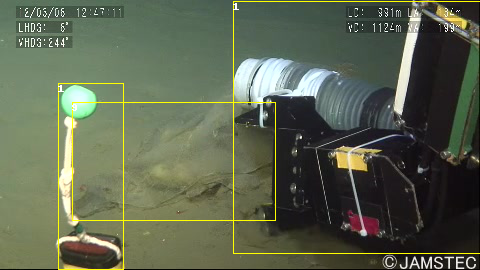

In [432]:
display_groundtruth('vid_000143_frame0000013.jpg', val)


In [437]:
val[val.duplicated(['image_id'])]

image_id     id                    file_name  category_id  \
35          34  11462  vid_000021_frame0000001.jpg            1   
36          34  11463  vid_000021_frame0000001.jpg            4   
38          35  11315  vid_000021_frame0000018.jpg            1   
39          35  11316  vid_000021_frame0000018.jpg            1   
41          36  11858  vid_000021_frame0000019.jpg            1   
...        ...    ...                          ...          ...   
1899       855  11210  vid_000329_frame0000016.jpg            3   
1900       855  11211  vid_000329_frame0000016.jpg            1   
1902       856   9791  vid_000337_frame0000160.jpg            3   
1903       856   9792  vid_000337_frame0000160.jpg            3   
1904       856   9793  vid_000337_frame0000160.jpg            3   

                                                   bbox  width  height  
35    [445.0019607843137, 221.00196078431372, 33.996...    480     270  
36    [120.0028409090909, 252.00280898876406, 18.993...    480     270  
38    [373.0019607843137, 240.00196078431372, 35.996...    480     270  
39    [444.0019607843137, 221.00196078431372, 35.996...    480     270  
41    [373.0019607843137, 241.00196078431372, 34.996...    480     270  
...                                                 ...    ...     ...  
1899  [8.001960784313725, 148.00196078431372, 57.996...    480     270  
1900  [146.00196078431372, 195.00196078431372, 302.9...    480     270  
1902  [26.002512562814072, 233.00196078431372, 68.99...    480     270  
1903  [196.00196078431372, 64.00196078431372, 22.996...    480     270  
1904  [263.0019607843137, 85.00196078431372, 25.9960...    480     270  

[1048 rows x 7 columns]